# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [ ]:
# student details 1: Nadav Izhaki 329087852
# student details 2: 
# student details 3: 

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.

<pre>
Dataset Explanation:
    This dataset contains face images labeled as male or female. 
    It includes 1747 male and 1747 female images for training, and 100 male + 100 female images for both testing and validation. 
    The training and test are balanced, each containing roughly 50% male and 50% female images.
    All images were automatically cropped to show only the face using a tool called MTCNN.

I’m using this dataset to train a CNN (Convolutional Neural Network) model, 
which includes convolutional layers for feature extraction and fully connected layers at the end for decision making. 
The model will be used for binary classification to recognize whether a face image is male (1) or female (0).


Link to dataset: https://www.kaggle.com/datasets/gpiosenka/gender-classification-from-an-image

Note: You need to download the folder named gender_rev2 and then rename its folder to data.
</pre>

## Part 2 - Initial Preparations 

In [2]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as F

In [3]:
# Check if torch is installed
print(f"Using torch version {torch.__version__}")

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} deivce") 

Using torch version 2.5.1+cu121
Using cuda deivce


In [ ]:
# Start Hyperparameters
CLASS_NAMES = ["male", "female"]

RANDOM_SEED = 142  # Seed for reproducibility

BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_UNITS = 64  # Number of filters in the convolutional layers
KERNEL_SIZE = 3  # Size of the convolutional filters (3x3)
STEP_SIZE = 1  # Stride of the convolutional filters (1 pixel step)
POOL_KERNEL_SIZE = 2  # Size of the max pooling window (2x2)

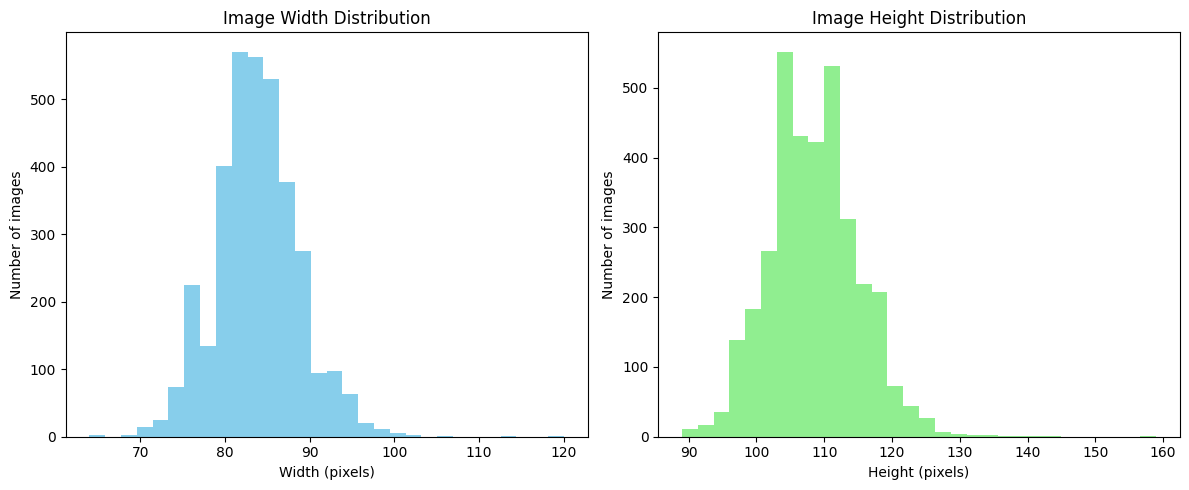

In [4]:
# Function to plot the distribution of image sizes in a directory

def plot_image_size_distribution(root_dir):
    widths = []
    heights = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.jpg')):
                path = os.path.join(subdir, file)
                try:
                    img = Image.open(path)
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                except Exception as e:
                    print(f"Error loading {path}: {e}")


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, color='skyblue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Number of images')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, color='lightgreen')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Number of images')

    plt.tight_layout()
    plt.show()


plot_image_size_distribution('data/train')

Based on the image size distribution, I chose 100×128 pixels. The function resizes each image to fit within this box without distortion, leaving smaller images unchanged, then pads them evenly with black borders to reach the exact size.

In [5]:
def pad_to_100x128(img):
    # Resize to fit inside 100x128, keep aspect ratio
    img.thumbnail((100, 128))  # modifies img in-place

    # Get new size
    w, h = img.size

    # Compute padding amounts (left, top, right, bottom)
    pad_left = (100 - w) // 2
    pad_top = (128 - h) // 2
    pad_right = 100 - w - pad_left
    pad_bottom = 128 - h - pad_top

    # Pad the image
    return F.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=0)


transform = transforms.Compose([
    transforms.Lambda(pad_to_100x128),
    transforms.ToTensor()
])

In [6]:
# Load datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
val_dataset   = datasets.ImageFolder(root='data/valid', transform=transform)
test_dataset  = datasets.ImageFolder(root='data/test', transform=transform)

print(f"Label map of datset: {train_dataset.class_to_idx}")


Label map of datset: {'female': 0, 'male': 1}


In [ ]:

def plot_images_examples(datset, class_names):
    torch.manual_seed(142)
    fig = plt.figure(figsize=(9,9))
    rows, cols = 4, 4

    for i in range(1, rows*cols + 1):
        random_idx = torch.randint(0, len(datset), size=[1]).item()
        img, label = datset[random_idx]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(class_names[label])
        plt.axis(False)

    plt.show()


plot_images_examples(datset=train_dataset, class_names=CLASS_NAMES)

## Part 3 - Experiments
You could add as many code cells as needed

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

## Part 5 - Apply on test and show model performance estimation